In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
import h5py
import numpy as np
particle_data_path ='dataset/brightfield_particles.hdf5'
with h5py.File(particle_data_path , 'r') as f:
    print(f['data'].shape)
    print(np.unique(f['labels'],return_counts=True))

(41350, 16, 201)
(array([0, 1, 2, 3]), array([32462,  8659,    60,   169]))


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
# from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torchvision.models.vision_transformer import VisionTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [4]:
from torchvision.transforms import v2    
def compute_normalization_stats(h5_path, classes=None):
    """
    Compute mean and standard deviation for z-score normalization.
    
    Args:
        h5_path (str): Path to HDF5 file
        classes (list, optional): List of classes to include in computation
        
    Returns:
        tuple: (mean, std) computed across all data points
    """
    with h5py.File(h5_path, 'r') as h5_file:
        data = h5_file['data'][:]
        labels = h5_file['labels'][:]
        
        if classes is not None:
            # Filter data for selected classes
            mask = np.isin(labels, classes)
            data = data[mask]
        
        # Compute statistics across all dimensions
        mean = np.mean(data)
        std = np.std(data)
        
        print(f"Computed statistics: mean = {mean:.4f}, std = {std:.4f}")
        
        return mean, std
        
class ParticleDataset(Dataset):
    """Custom Dataset for particle data with flexible class selection and normalization."""
    def __init__(self, h5_path, classes=[0, 1], transform=None, mean=None, std=None,padding=False,indices=None):
        self.h5_file = h5py.File(h5_path, 'r')
        data = self.h5_file['data'][:]
        labels = self.h5_file['labels'][:]
        self.padding = padding
        # Filter data for selected classes
        mask = np.isin(labels, classes)
        if indices is None:
            self.data = data[mask][:]
            self.labels = labels[mask][:] 
        else:
            self.data = data[mask][indices]
            self.labels = labels[mask][indices]
        
        # Create class mapping to handle non-consecutive class indices
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.num_classes = len(classes)
        
        # Map original labels to new consecutive indices
        self.labels = np.array([self.class_to_idx[label] for label in self.labels])
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get particle data
        particle = self.data[idx]  # Shape: (16, 201)
        
        # Apply normalization if mean and std are provided
        if self.mean is not None and self.std is not None:
            particle = (particle - self.mean) / self.std
        
        # Convert to torch tensor for better interpolation
        particle_tensor = torch.FloatTensor(particle).unsqueeze(0)  # Add channel dim
        
        # Resize to (16, 16) using bicubic interpolation
        resized = torch.nn.functional.interpolate(
            particle_tensor.unsqueeze(0),  # Add batch dim
            size=(16, 201),
            mode='bicubic',
            align_corners=True
        ).squeeze(0).squeeze(0)  # Remove batch and channel dims
        
        final_tensor = resized.unsqueeze(0).repeat(3, 1, 1)  # Repeat across 3 channels
        
        if self.transform:
            final_tensor = self.transform(final_tensor)
        
        # Create one-hot encoded label
        label_idx = self.labels[idx]
        # label_onehot = torch.zeros(self.num_classes)
        # label_onehot[label_idx] = 1
        
        # return final_tensor, label_onehot
        return final_tensor , label_idx
    def close(self):
        self.h5_file.close()     

In [5]:
import torch 

def distance_matrix(a, b):
    a_expanded = a.view(-1, 1)
    b_expanded = b.view(1, -1)

    return torch.abs(a_expanded - b_expanded)

def knn_divergence(points_x, points_y, k, smoothing_kernel=None,reduction='mean',method="fraction"):
    xx_distances = distance_matrix(points_x, points_x)
    xy_distances = distance_matrix(points_x, points_y) # one row for every sample in x, one col for every sample in y

    # if the sets have different sizes
    # e.g. y has twice as many points -> the distance to the 3rd closest point in x should be the same as the distance to the 6th point in y
    k_multiplier = points_y.shape[0] / points_x.shape[0]

    k_dist_xx = torch.sort(xx_distances, dim=1)[0][:, k]
    k_dist_xy = torch.sort(xy_distances, dim=1)[0][:, (k * k_multiplier).to(torch.int)]
    # optional: smoothen the distances 
    # (so that it matters less whether a point is the i-th or the (i+1)-th closest neighbor)
    if smoothing_kernel != None:
            # torch conv1d demands a channel dimension, hence the (un)squeezing
            k_dist_xx = torch.nn.functional.conv1d(k_dist_xx.unsqueeze(1), weight=smoothing_kernel.view(1, 1, -1)).flatten(1)
            k_dist_xy = torch.nn.functional.conv1d(k_dist_xy.unsqueeze(1), weight=smoothing_kernel.view(1, 1, -1)).flatten(1)
    if method== "fraction":
        output = (1 - k_dist_xx / k_dist_xy)**2
    else:
        output = (k_dist_xx - k_dist_xy)**2
    if reduction=='mean':
        return torch.mean(output)
    else:
        return output

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def generate_label_distribution(num_points=10000, mean=76, std=22.5, min_value=10, max_value=None):
    """
    Generate a tensor of points sampled from a normal distribution with specified mean and standard deviation
    while rejecting points outside the optional min and max value constraints.
    
    Args:
        num_points (int): Number of points to generate
        mean (float): Mean of the distribution
        std (float): Standard deviation of the distribution
        min_value (float, optional): Minimum value of the distribution (inclusive)
        max_value (float, optional): Maximum value of the distribution (inclusive)
    
    Returns:
        torch.Tensor: Tensor of generated points within the specified range
    """
    points = torch.empty(0)  # Initialize an empty tensor to store valid points

    while points.numel() < num_points:
        # Generate points from normal distribution
        generated_points = torch.normal(mean=mean, std=std, size=(num_points,))
        
        # Filter points based on the min and max values
        if min_value is not None:
            generated_points = generated_points[generated_points >= min_value]
        if max_value is not None:
            generated_points = generated_points[generated_points <= max_value]
        
        # Add the valid points to the tensor
        points = torch.cat((points, generated_points))
    # Return only the first `num_points` points
    return points[:num_points]

In [7]:
from torchsummary import summary
# resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# # resnet .fc = nn.Linear(resnet.fc.in_features, 1)
# resnet .fc = nn.Sequential(
#     nn.Linear(resnet.fc.in_features, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1))
# summary(resnet, input_size=(3, 16, 201),device='cpu')

In [8]:
import numpy as np
import random
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
from torch.utils.data import DataLoader

DEVICE = "cuda:11"
# Device configuration
device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# classes = [0]
transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
])

mean, std = compute_normalization_stats('dataset/brightfield_particles.hdf5', classes=[0])
batch_size_80 = 10000
num_points_80 = 30000
batch_size_300 = 8000
num_points_300 = 16000

dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                            classes=[0],
                            mean=mean,
                            std=std,
                            padding=True,
                            transform = transform,
                            indices=list(range(0, batch_size_80*3)),
                         )
dataset_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                            classes=[1],
                            mean=mean,
                            std=std,
                            padding=True,
                            transform = transform,
                            indices=list(range(0, 8000)),
                         )
# dataset_80_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
#                             classes=[0,1],
#                             mean=mean,
#                             std=std,
#                             padding=True,
#                             transform = transform,
#                             indices=None,
#                          )

dataloader_80 = DataLoader(dataset_80, batch_size=batch_size_80 , shuffle=True)
label_points_80 = generate_label_distribution(num_points_80, mean=76, std=22.5)

dataloader_300 = DataLoader(dataset_300, batch_size=batch_size_300 , shuffle=True)
label_points_300 = generate_label_distribution(num_points_300, mean=302, std=25)

# dataloader_80_300 = DataLoader(dataset_80_300, batch_size=2048 , shuffle=True)

Using device: cuda:11
Computed statistics: mean = 7407.4357, std = 1323.8027


In [10]:
def train_resnet(model, dataloaders, label_points, device, num_epochs=10, learning_rate=1e-2):
    """
    Train ResNet model using KNN divergence loss with early stopping and learning rate scheduling.
    
    Args:
        model (torch.nn.Module): ResNet model
        dataloader (torch.utils.data.DataLoader): Training dataloader
        label_points (torch.Tensor): Pre-generated label points
        device (torch.device): Device to train on
        num_epochs (int): Number of training epochs
        learning_rate (float): Learning rate for optimizer
    
    Returns:
        model: Trained model
        best_loss: Best training loss achieved
    """
    # Move label points to the specified device
    labels = [label.to(device, non_blocking=True) for label in label_points] 
    # labels_80, labels_300 = labels[0],labels[1] 
    # Prepare k values for KNN divergence
    ks = [torch.arange(2, label_point.shape[0]//10, dtype=torch.int) for label_point in label_points]    
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Setup learning rate scheduler with patience of 8
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=8, factor=0.5
    )
    
    model.to(device)
   
    # Early stopping parameters
    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        batch_count = 0
        if epoch%5==0:
            labels = [generate_label_distribution(num_points_80, mean=76, std=22.5).to(device, non_blocking=True)]
            # labels = [generate_label_distribution(num_points_300, mean=302, std=25).to(device, non_blocking=True)]
        for idx, (label, dataloader) in enumerate(zip(labels, dataloaders)):
                for batch_images, _ in dataloader:
                    batch_count += 1
                    gt = torch.clone(label)
                    batch_images = batch_images.to(device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass: generate predictions
                    batch_predictions = model(batch_images)
                    
                    # Compute KNN divergence loss
                    loss = knn_divergence(batch_predictions, gt, ks[idx],method="mse")
                    
                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = total_loss / batch_count
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.2e}')
        
        # Learning rate scheduling
        scheduler.step(avg_loss)
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                # Restore best model
                model.load_state_dict(best_model_state)
                break
    
    return model, best_loss

In [11]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
dataloaders = (dataloader_80,)
label_points = (label_points_80,)
# resnet .fc = nn.Linear(resnet.fc.in_features, 1)
# resnet .fc = nn.Sequential(
#     nn.Linear(resnet.fc.in_features, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 1)
# )
resnet .fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1),
)
resnet,best_loss = train_resnet(resnet, dataloaders, label_points, device, num_epochs=400)
resnet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch [1/400], Loss: 2143.5097, LR: 1.00e-02
Epoch [2/400], Loss: 802.4837, LR: 1.00e-02
Epoch [3/400], Loss: 143.2722, LR: 1.00e-02
Epoch [4/400], Loss: 17.8754, LR: 1.00e-02
Epoch [5/400], Loss: 6.4463, LR: 1.00e-02
Epoch [6/400], Loss: 19.4042, LR: 1.00e-02
Epoch [7/400], Loss: 27.8288, LR: 1.00e-02
Epoch [8/400], Loss: 25.3498, LR: 1.00e-02
Epoch [9/400], Loss: 14.7968, LR: 1.00e-02
Epoch [10/400], Loss: 6.4450, LR: 1.00e-02
Epoch [11/400], Loss: 2.7425, LR: 1.00e-02
Epoch [12/400], Loss: 1.2808, LR: 1.00e-02
Epoch [13/400], Loss: 0.9241, LR: 1.00e-02
Epoch [14/400], Loss: 0.9273, LR: 1.00e-02
Epoch [15/400], Loss: 0.4195, LR: 1.00e-02
Epoch [16/400], Loss: 0.4462, LR: 1.00e-02
Epoch [17/400], Loss: 0.4460, LR: 1.00e-02
Epoch [18/400], Loss: 0.2618, LR: 1.00e-02
Epoch [19/400], Loss: 0.2101, LR: 1.00e-02
Epoch [20/400], Loss: 0.2062, LR: 1.00e-02
Epoch [21/400], Loss: 0.2860, LR: 1.00e-02
Epoch [22/400], Loss: 0.1836, LR: 1.00e-02
Epoch [23/400], Loss: 0.2392, LR: 1.00e-02
Epoch [2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet.eval()
resnet(dataset_80[0][0].unsqueeze(0).to(device))

tensor([[125.3137]], device='cuda:11', grad_fn=<AddmmBackward0>)

In [37]:
plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indices = None
                         )
plot_dataloader_80 = DataLoader(plot_dataset_80 , batch_size=len(plot_dataset_80), shuffle=False)
with torch.no_grad():
    out= next(iter(dataloader_80))[0]
    out = resnet(out.to(device))
    out = out.cpu().detach().numpy()

In [39]:
out.max()

151.37038

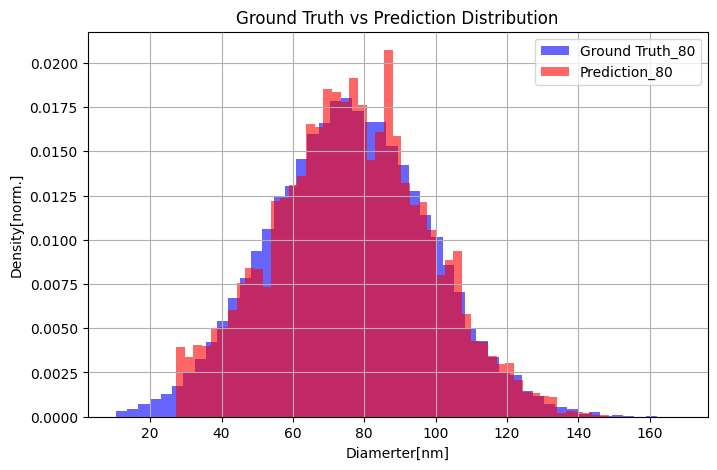

In [15]:
# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(label_points_80 , bins=50, alpha=0.6, label='Ground Truth_80', color='blue', density=True)
plt.hist(out, bins=50, alpha=0.6, label='Prediction_80', color='red', density=True)

# Labels and legend
plt.xlabel('Diamerter[nm]')
plt.ylabel('Density[norm.]')
plt.title('Ground Truth vs Prediction Distribution')
plt.legend()
plt.grid(True)
# Show plot
plt.show()


In [16]:
plot_dataset_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[1],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indices = None
                         )
plot_dataloader_300 = DataLoader(plot_dataset_300 , batch_size=len(plot_dataset_300))

with torch.no_grad():
    out_2 = next(iter(plot_dataloader_300))[0]
    out_2   = resnet(out_2.to(device))
    out_2 = out_2.cpu().detach().numpy()
label_points_300 = generate_label_distribution(len(plot_dataset_300), mean=302, std=25)
print(out_2.mean())

71.89583


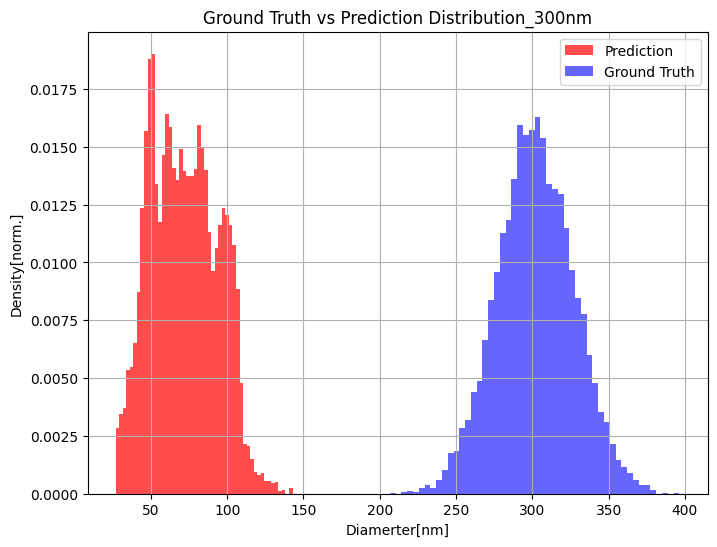

In [17]:
import matplotlib.pyplot as plt
# Example list of values
# values =out_2+(302-out_2.mean())
values =out_2
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=50, color='red',label='Prediction',alpha=0.7, density=True)
plt.hist(label_points_300  , bins=50, alpha=0.6, label='Ground Truth', color='blue', density=True)
# Add labels
# Labels and legend
plt.xlabel('Diamerter[nm]')
plt.ylabel('Density[norm.]')
plt.title('Ground Truth vs Prediction Distribution_300nm')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [18]:
def compute_contrast(imgs: torch.Tensor, dim=(1,2,3)):
    return imgs.amax(dim=dim) - imgs.amin(dim=dim)
def compute_contrast(imgs: torch.Tensor, dim=(1, 2, 3)):
    """
    Compute contrast values for a batch of images.
    Args:
        imgs (torch.Tensor): Batch of images of shape (B, C, H, W).
        dim (tuple): Dimensions over which to compute the contrast.
    Returns:
        torch.Tensor: Contrast value for each image in the batch (B,).
    """
    return (imgs.amax(dim=dim) - imgs.amin(dim=dim)) / imgs.mean(dim=dim)
def compute_contrast(imgs: torch.Tensor, dim=(1,2,3)):
    return (imgs.amax(dim=dim) - imgs.amin(dim=dim))/(imgs.amax(dim=dim) + imgs.amin(dim=dim))
    
plot_dataset_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[1],
                          mean=None,
                          std=None,
                          padding=True,
                        transform = None,
                        indices = None
                         )
plot_dataloader_300 = DataLoader(plot_dataset_300 , batch_size=20000)
plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=None,
                          std=None,
                          padding=True,
                        transform = None,
                        indices = None
                         )
plot_dataloader_80 = DataLoader(plot_dataset_80 , batch_size=30000)
with torch.no_grad():
    out = next(iter(plot_dataloader_80))[0]
    out_2 = next(iter(plot_dataloader_300))[0]
    out   = compute_contrast(out)
    out_2   = compute_contrast(out_2)
    out = out.cpu().detach().numpy()
    out_2 = out_2.cpu().detach().numpy()

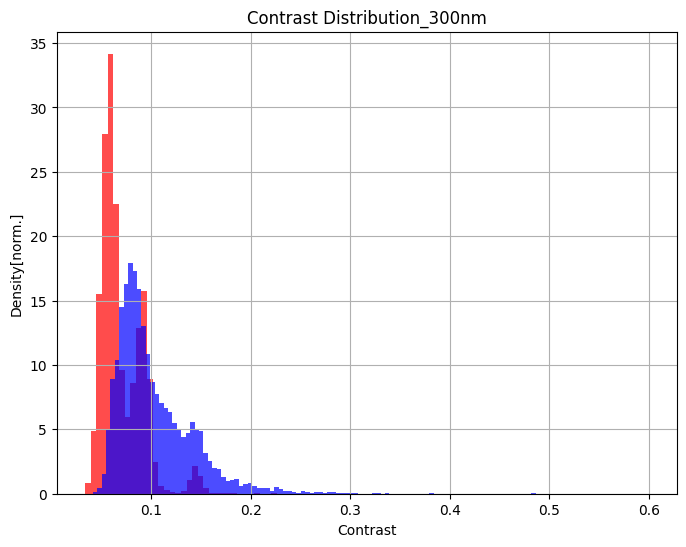

In [19]:
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(out, bins=100, color='red',alpha=0.7, label="80nm",density=True)
plt.hist(out_2, bins=100, color='blue',alpha=0.7,label="80nm", density=True)
# Add labels
# Labels and legend
plt.xlabel('Contrast')
plt.ylabel('Density[norm.]')
plt.title('Contrast Distribution_300nm')
plt.grid(True)

# Show plot
plt.show()

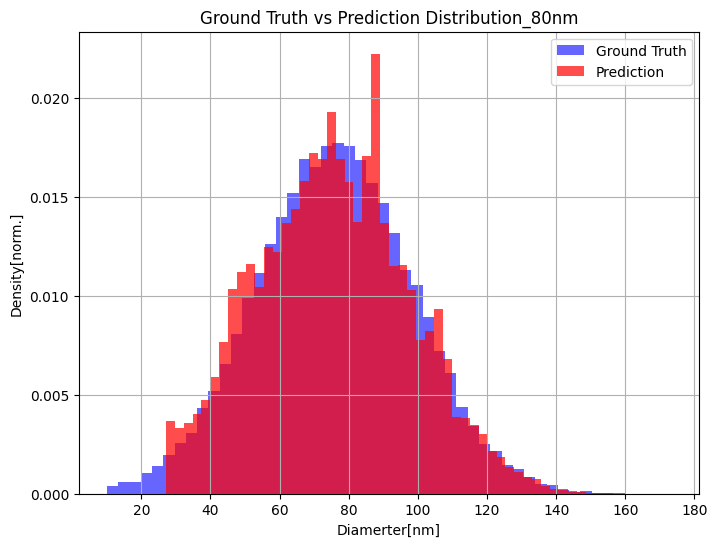

In [48]:
plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indices = None
                         )
plot_dataloader_80 = DataLoader(plot_dataset_80 , batch_size=len(plot_dataset_80), shuffle=False)

with torch.no_grad():
    out_2 = next(iter(plot_dataloader_80))[0]
    out_2   = resnet(out_2.to(device))
    out_2 = out_2.cpu().detach().numpy()
    
label_points_80 = generate_label_distribution(num_points_80, mean=76, std=22.5)

plt.figure(figsize=(8, 6))

# Plot the histogram

plt.hist(label_points_80  , bins=50, alpha=0.6, label='Ground Truth', color='blue', density=True)
plt.hist(out_2 , bins=50, color='red',label='Prediction',alpha=0.7, density=True)
# Add labels
# Labels and legend
plt.xlabel('Diamerter[nm]')
plt.ylabel('Density[norm.]')
plt.title('Ground Truth vs Prediction Distribution_80nm')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

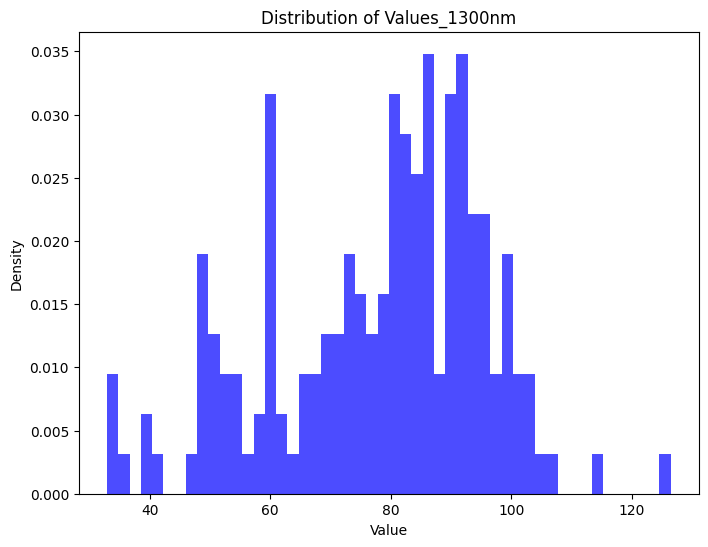

In [21]:
plot_dataset_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[3],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indices=None
                         )
plot_dataloader_300 = DataLoader(plot_dataset_300, batch_size=len(plot_dataset_300))
with torch.no_grad():
    out_3 = next(iter(plot_dataloader_300))[0]
    out_3  = resnet(out_3.to(device))
    out_3 = out_3.cpu().detach().numpy()
import matplotlib.pyplot as plt

# Example list of values
values = out_3
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=50, density=True, color='blue', alpha=0.7)

# Add labels
plt.title('Distribution of Values_1300nm')
plt.xlabel('Value')
plt.ylabel('Density')

# Show plot
plt.show()

In [22]:
with torch.no_grad():
    output_map = resnet.conv1(dataset_80[0][0].unsqueeze(0).to(device)).squeeze(0).cpu()

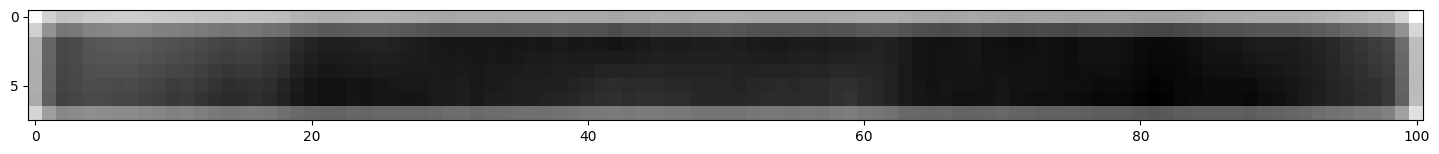

In [23]:
fig, ax = plt.subplots(figsize=(18, 10))
f=torch.clone(output_map[3])
# f[f<(f.mean())]=0
ax.imshow(f,cmap='gray')
plt.show()

In [155]:
plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indices = None
                         )
plot_dataloader_80 = DataLoader(plot_dataset_80 , batch_size=len(plot_dataset_80), shuffle=False)
with torch.no_grad():
    imgs = next(iter(plot_dataloader_80))[0]  # (10000,3,16,201)
    img = imgs[2000].unsqueeze(0)  # (1,3,16,201)
    
    # Get prediction for original image
    size_1 = resnet(img.to(device)).cpu()
    size_1 = size_1.squeeze(0)
    
    # Flip the image horizontally (along the last dimension)
    img_flipped = torch.flip(img, dims=[-1])
    
    # Get prediction for flipped image
    size_2 = resnet(img_flipped.to(device)).cpu()
    size_2 = size_2.squeeze(0)
    
    # Print both predictions
    print(f"Original image size prediction: {size_1.item():.3f}")
    print(f"Flipped image size prediction: {size_2.item():.3f}")
    print(f"Absolute difference: {abs(size_1.item() - size_2.item()):.3f}")

Original image size prediction: 52.191
Flipped image size prediction: 52.380
Absolute difference: 0.189


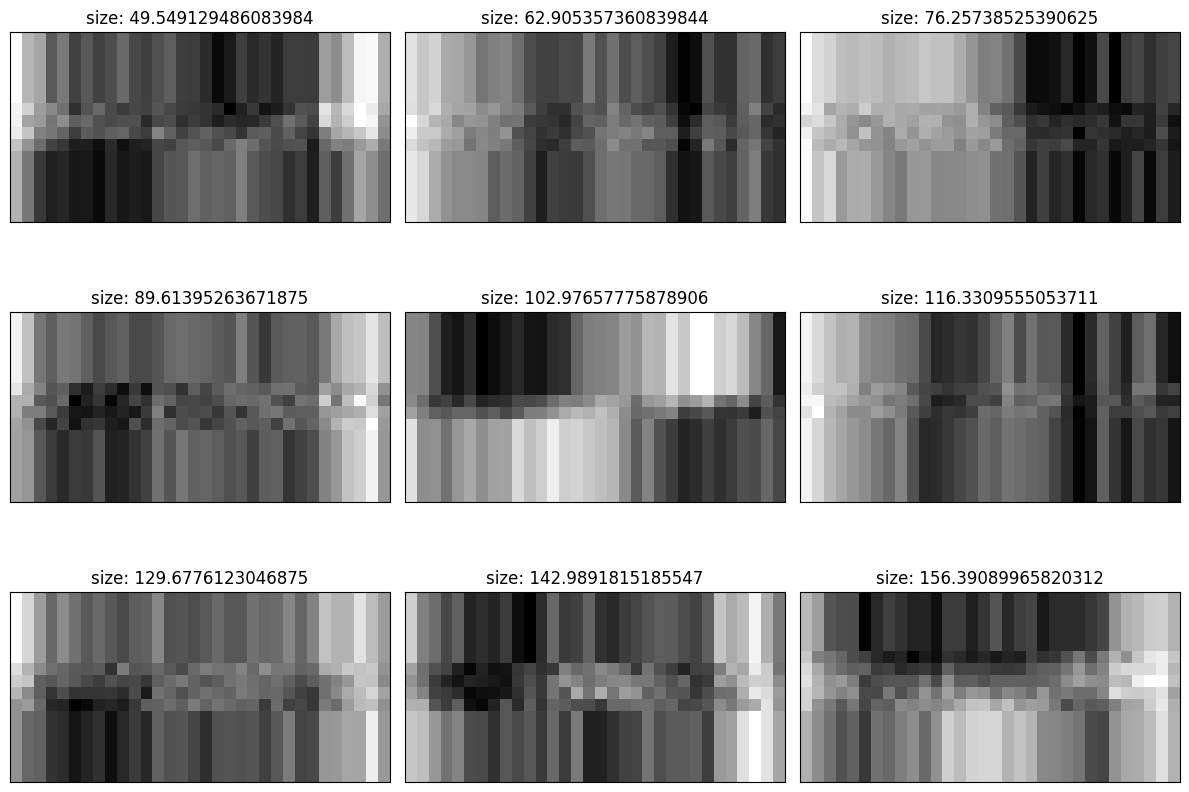

In [25]:
import torch
import matplotlib.pyplot as plt

plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                            transform = None
                         )
plot_dataloader = DataLoader(plot_dataset_80, batch_size=10000)
with torch.no_grad():
    imgs = next(iter(plot_dataloader))[0]  # (10000,3,16,201)
    sizes = resnet(imgs.to(device)).cpu() 
    
max_size, max_idx = sizes.max(dim=0)
min_size, min_idx = sizes.min(dim=0)

# Compute middle size (median)
mid_size = sizes.median()
mid_idx = (sizes - mid_size).abs().argmin()
mid_idx = torch.tensor([mid_idx], dtype=torch.int64)

# Create 9 intermediate values between min, mid, and max
intermediate_sizes, intermediate_indices = [], []
for fraction in torch.linspace(0, 1, steps=9):
    interp_size = min_size + fraction * (max_size - min_size)
    closest_idx = (sizes - interp_size).abs().argmin()
    intermediate_sizes.append(sizes[closest_idx])
    intermediate_indices.append(closest_idx)

# Convert indices to tensor
intermediate_indices = torch.tensor(intermediate_indices, dtype=torch.int64)

# Get images and resize them
resized_images = [
    torch.nn.functional.interpolate(
        imgs[idx][0:1].unsqueeze(0), size=(16, 32), mode="bilinear", align_corners=False
    ).squeeze(0)[0]
    for idx in intermediate_indices
]

# Create 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

# Plot images
for ax, img, size in zip(axes.flat, resized_images, intermediate_sizes):
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(f"size: {size.item()}")

# Adjust layout and show
plt.tight_layout()
plt.show()

In [26]:
import sys
import contextlib
import torch.nn.functional as F
model = resnet
def remove_all_hooks(model):
    """Removes all forward and backward hooks from the model."""
    for module in model.modules():  
        if hasattr(module, "_forward_hooks"):
            module._forward_hooks.clear()
        if hasattr(module, "_backward_hooks"):
            module._backward_hooks.clear()
        if hasattr(module, "_full_backward_hooks"):
            module._full_backward_hooks.clear()

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradient = None
        
        self.target_layer.register_forward_hook(self._save_feature_maps)
        self.target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_feature_maps(self, module, input, output):
        self.feature_maps = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0].detach()
    
    def generate_heatmap(self, input_image, target_index=None):
        self.model.eval()
        
        # Get model prediction
        output = self.model(input_image)
        
        if target_index is None:
            target = output
        else:
            target = output[:, target_index]

        self.model.zero_grad()
        target.backward()
        
        # Calculate weights
        weights = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        
        # Generate weighted combination of feature maps
        cam = torch.sum(weights * self.feature_maps, dim=1, keepdim=True)
        
        # Apply ReLU
        cam = F.relu(cam)
        # Interpolate to match the width of the input image
        # Note: We're only interpolating the width (201) since height is different
        cam = F.interpolate(
            cam,
            size=(input_image.shape[2], input_image.shape[3]),  # (16, 201)
            mode='bicubic',
            align_corners=False
        )
        
        heatmap = cam.cpu().numpy()[0, 0]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        
        return heatmap
    def remove_hooks(self):
        """Remove all registered hooks from the target layer."""
        if hasattr(self.target_layer, "_forward_hooks"):
            self.target_layer._forward_hooks.clear()
        if hasattr(self.target_layer, "_backward_hooks"):
            self.target_layer._backward_hooks.clear()
        if hasattr(self.target_layer, "_full_backward_hooks"):
            self.target_layer._full_backward_hooks.clear()

def apply_heatmap(image: np.ndarray, heatmap: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    """
    Apply heatmap overlay to original image.
    
    Args:
        image: Original image (C, H, W) normalized
        heatmap: Heatmap array (H, W)
        alpha: Transparency factor for overlay
    """
    # Denormalize image to [0,1] range
    image = image.copy()
    for c in range(image.shape[0]):
        channel = image[c]
        channel_min, channel_max = channel.min(), channel.max()
        image[c] = (channel - channel_min) / (channel_max - channel_min)
    
    # Convert to (H, W, C)
    image = np.transpose(image, (1, 2, 0))
    
    # Convert heatmap to RGB (H, W, 3)
    heatmap_rgb = np.stack([heatmap, np.zeros_like(heatmap), np.zeros_like(heatmap)], axis=-1)
    
    # Create overlay
    overlay = image * (1 - alpha) + heatmap_rgb * alpha
    
    return overlay
remove_all_hooks(model)
model = resnet.to(device)
# target_layer =  model.layer4[1].conv2
target_layer =  model.layer1[1].conv2
images = [plot_dataset_80[idx][0] for idx in intermediate_indices]
def generate_RAM(model,image,traget_layer):    
    model.eval()
    grad_cam = GradCAM(model, target_layer) 
    with torch.no_grad():
        image_tensor = image.to(device).unsqueeze(0)  # Add batch dimension
    heatmap = grad_cam.generate_heatmap(image_tensor)
    grad_cam.remove_hooks()
    return heatmap
heatmaps = [generate_RAM(model,image,target_layer) for image in images]

In [27]:
def plot_heatmap(image_tensor,heatmap):
    # Visualize
    plt.figure(figsize=(15, 4))
    # Original image - denormalize for visualization
    img = image_tensor.cpu().numpy()
    img_norm = np.zeros_like(img)
    for c in range(img.shape[0]):
        channel = img[c]
        channel_min, channel_max = channel.min(), channel.max()
        img_norm[c] = (channel - channel_min) / (channel_max - channel_min)
    plt.subplot(3, 1, 1)
    plt.imshow(np.transpose(img_norm, (1,2,0)))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(3, 1, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Heatmap')
    plt.axis('off')
    plt.subplot(3, 1, 3)
    overlay = apply_heatmap(image_tensor.cpu().numpy(), heatmap)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

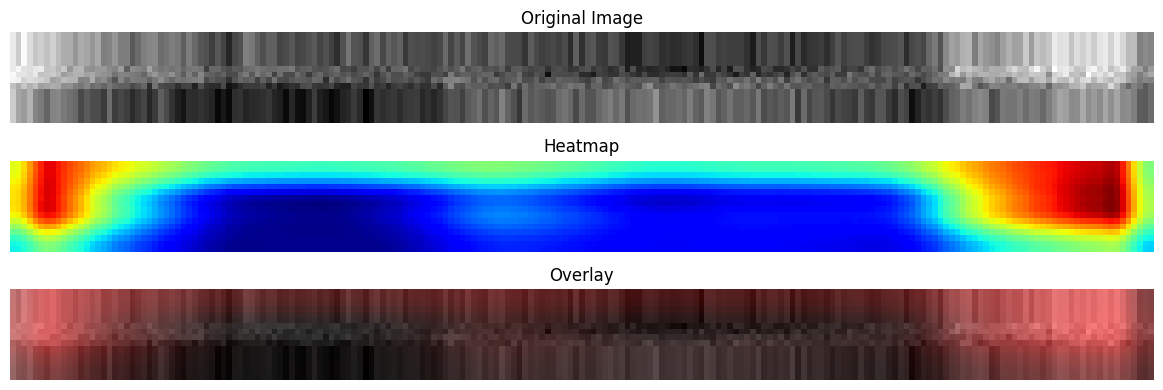

In [28]:
plot_heatmap(images[0],heatmaps[0])

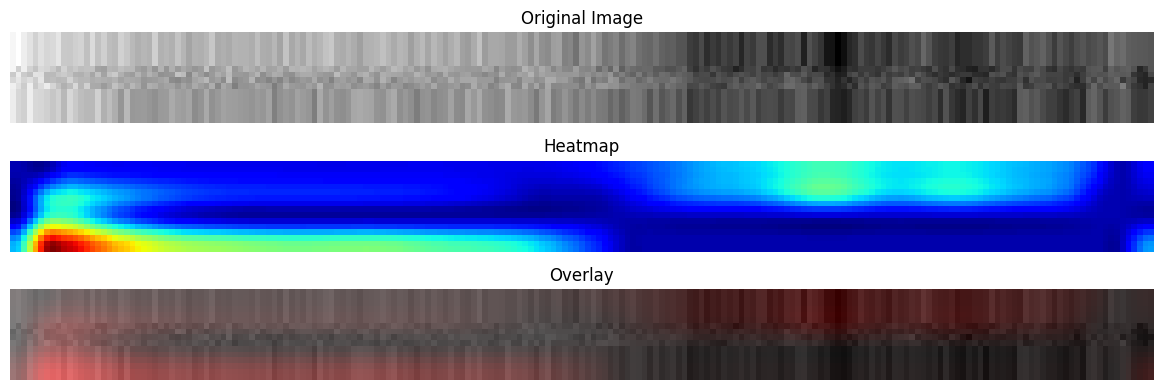

In [29]:
plot_heatmap(images[2],heatmaps[2])

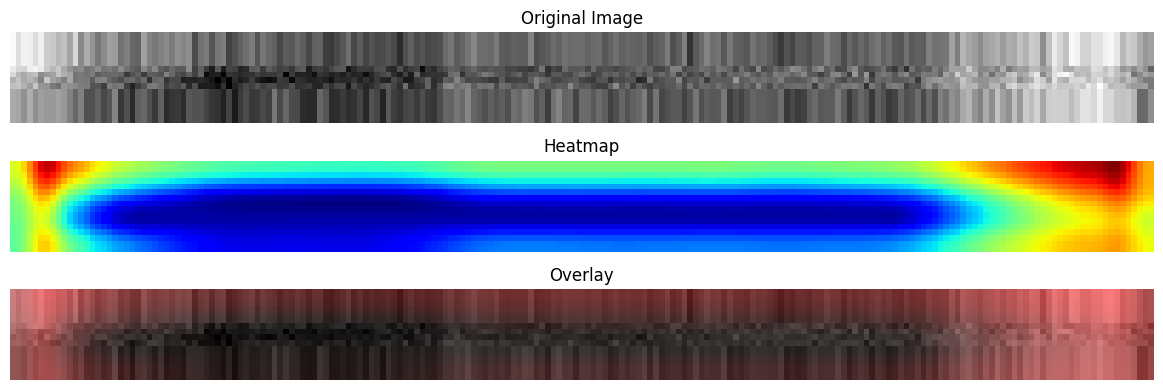

In [30]:
plot_heatmap(images[3],heatmaps[3])

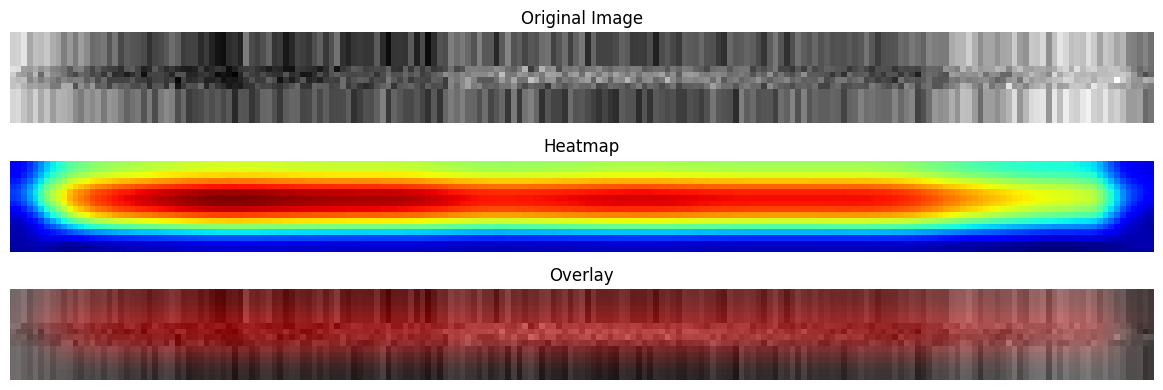

In [31]:
plot_heatmap(images[-2],heatmaps[-2])

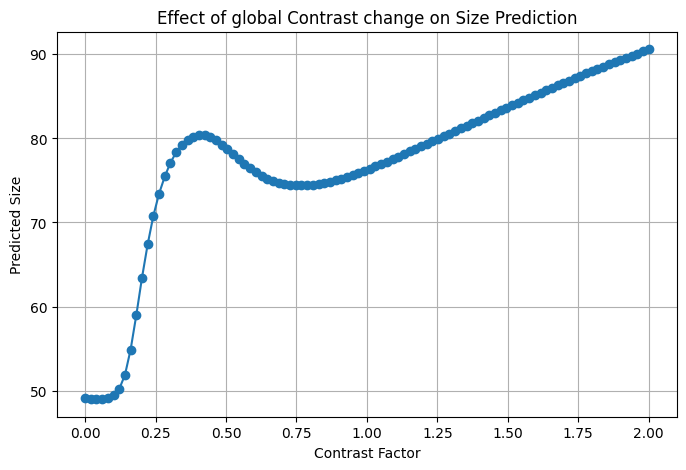

In [42]:
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np

def adjust_contrast(image, alpha, mean, std):
    """
    Adjusts the contrast of a normalized grayscale image.

    Args:
        image (torch.Tensor): Normalized image tensor (C, H, W).
        alpha (float): Contrast adjustment factor (>1 for high contrast, <1 for low).
        mean (float): Mean used for dataset normalization.
        std (float): Std deviation used for dataset normalization.

    Returns:
        torch.Tensor: Contrast-adjusted image (still normalized).
    """
    # Denormalize the image
    image_denorm = image * std + mean  # Convert back to original intensity range

    # Compute image mean in its original scale
    img_mean = image_denorm.mean()

    # Apply contrast change
    image_contrast = alpha * (image_denorm - img_mean) + img_mean

    # Re-normalize the image
    image_norm = (image_contrast - mean) / std

    return image_norm
    
def test_contrast_sensitivity(model, image, device="cpu"):
    """
    Applies different contrast values to an image, runs the model, and plots size prediction vs contrast.
    
    Args:
        model: The trained model for size prediction.
        image: A PIL Image or a torch tensor (C, H, W) in range [0, 1].
        device: The device where the model is running ('cpu' or 'cuda').
    """
    contrast_values = np.linspace(0, 2, 100)  # Contrast from 0 (gray) to 2 (high contrast)
    predictions = []
    
    model = model.to(device)
    model.eval()
    
    image = image.to(device) if isinstance(image, torch.Tensor) else TF.to_tensor(image).to(device)
    
    with torch.no_grad():
        for contrast in contrast_values:
            adjusted_image = adjust_contrast(image, contrast , mean, std)
            # adjusted_image = image*contrast 
            adjusted_image = adjusted_image.unsqueeze(0)  # Add batch dimension
            pred = model(adjusted_image).item()
            predictions.append(pred)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(contrast_values, predictions, marker='o', linestyle='-')
    plt.xlabel("Contrast Factor")
    plt.ylabel("Predicted Size")
    plt.title("Effect of global Contrast change on Size Prediction")
    plt.grid()
    plt.show()   
    return contrast_values, predictions
    
contrast_values,predictions = test_contrast_sensitivity(model, images[2], device=device)

In [33]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def extract_features(model, dataloader, device="cpu"):
    model = model.to(device)
    model.eval()
    features = []
    
    # Remove the final fully connected layer to use only the backbone
    backbone = nn.Sequential(*list(model.children())[:-1])
    backbone = backbone.to(device)
    
    with torch.no_grad():
        for images,_ in dataloader:  # Assuming dataloader returns only images
            images = images.to(device)
            feat = backbone(images)
            feat = torch.flatten(feat, start_dim=1)  # Flatten spatial dimensions
            features.append(feat.cpu().numpy())
    
    features = np.vstack(features)
    return features

def perform_pca_and_plot(model, dataloader, device="cpu", single_component=False):
    features = extract_features(model, dataloader, device)
    
    if features.shape[1] < 2 and not single_component:
        raise ValueError("Feature dimensionality is too low for PCA. Ensure the model extracts high-dimensional features.")
    
    n_components = 1 if single_component else 2
    pca = PCA(n_components=n_components)
    transformed_features = pca.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    if single_component:
        plt.scatter(range(len(transformed_features)), transformed_features[:, 0], alpha=0.7)
        plt.xlabel("Sample Index")
        plt.ylabel("Principal Component 1")
        plt.title("PCA - First Principal Component")
    else:
        plt.scatter(transformed_features[:, 0], transformed_features[:, 1], alpha=0.7)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title("PCA of Extracted Features")
    
    plt.show()

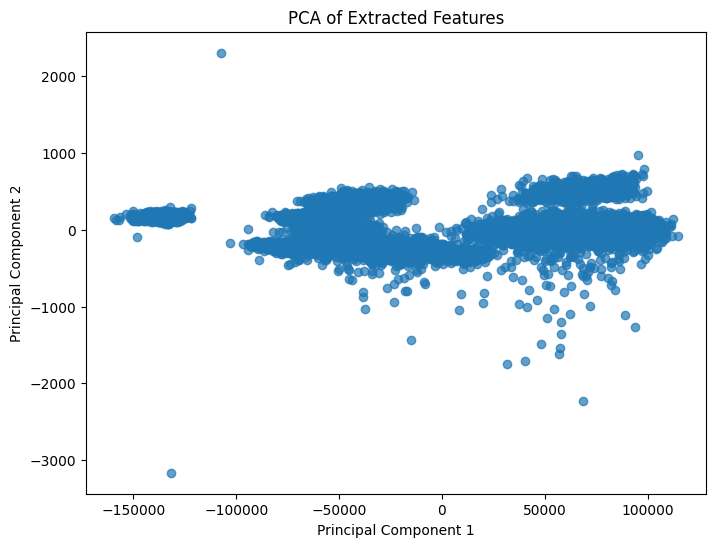

In [34]:
perform_pca_and_plot(resnet, plot_dataloader_80, device=device, single_component=False)

In [49]:
# plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
#                           classes=[0],
#                           mean=mean,
#                           std=std,
#                           padding=True,
#                         transform = None,
#                         indices = None
#                          )
# plot_dataloader_80 = DataLoader(plot_dataset_80 , batch_size=len(plot_dataset_80), shuffle=False)
# with torch.no_grad():
#     out = next(iter(plot_dataloader_80))[0]
#     out = resnet(out.to(device))
#     out = out.cpu().detach().numpy()

In [53]:
# out = out.squeeze(1)

In [68]:
# import os
# import numpy as np
# import tifffile as tiff
# import pandas as pd

# def save_data(images: np.ndarray, labels: np.ndarray, output_folder: str = "out_data"):
#     """
#     Saves images as 16-bit TIFF files and labels as a CSV file in the specified folder structure.
    
#     Args:
#         images (np.ndarray): Numpy array of images with shape (N, H, W), dtype float64.
#         labels (np.ndarray): Numpy array of labels with shape (N,), dtype float64.
#         output_folder (str): Root folder to save data.
#     """
    
#     # Create output directories
#     images_folder = os.path.join(output_folder, "images")
#     labels_folder = os.path.join(output_folder, "labels")
#     os.makedirs(images_folder, exist_ok=True)
#     os.makedirs(labels_folder, exist_ok=True)
    
#     # Normalize and convert images to 16-bit
#     images = (images).astype(np.uint16)  # Assuming images are normalized [0,1]
    
#     # Save images
#     for i in range(images.shape[0]):
#         image_path = os.path.join(images_folder, f"image_{i:05d}.tiff")
#         tiff.imwrite(image_path, images[i],photometric="minisblack")
    
#     # Save labels
#     labels_df = pd.DataFrame({"index": np.arange(len(labels)), "label": labels})
#     labels_path = os.path.join(labels_folder, "labels.csv")
#     labels_df.to_csv(labels_path, index=False)
    
#     print(f"Data saved successfully in '{output_folder}'")


In [187]:
import os
import numpy as np
import pandas as pd
from nd2 import ND2File
import cv2
from pathlib import Path
import re

def natural_sort_key(path):
    """Extracts numbers from folder names for natural sorting."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', path)]

def get_nd2_and_csv_paths(base_path, option):
    """
    Collect paths to .nd2 files and corresponding CSV files, ensuring sorted folders.
    
    Args:
        base_path (str): Base directory to search
        option (str): 'Brightfield' or 'Laser'
    
    Returns:
        list: List of tuples (nd2_path, [csv_paths])
    """
    if option not in {'Brightfield', 'Laser'}:
        raise ValueError("Option must be 'Brightfield' or 'Laser'")
    
    file_pairs = []
    mask_names = ['Captured Cy5.csv', 'Captured FITC.csv', 'Captured TRITC.csv']
    class_idx = {
        'Captured Cy5.csv': 0,
        'Captured FITC.csv': 1,
        'Captured TRITC.csv': 2,
    }
    class_idx_2024_11_29 = {
        'Captured Cy5.csv': 3,
        'Captured FITC.csv': 0,
        'Captured TRITC.csv': 1,
    }
    
    for root, dirs, _ in os.walk(base_path):
        if 'Metasurface' in Path(root).parts:
            dirs.sort(key=natural_sort_key)  # Ensure sorted order
            for folder in dirs:
                target_folder = os.path.join(root, folder, option)
                if os.path.isdir(target_folder):
                    for file in sorted(os.listdir(target_folder)):
                        if file.endswith('.nd2'):
                            nd2_path = os.path.join(target_folder, file)
                            csv_paths = []
                            for mask_name in mask_names:
                                csv_path = os.path.join(target_folder, mask_name)
                                if os.path.exists(csv_path):
                                    if '2024_11_29' in Path(root).parts:
                                        csv_paths.append((csv_path, class_idx_2024_11_29[mask_name]))
                                    else:
                                        csv_paths.append((csv_path, class_idx[mask_name]))
                            if csv_paths:
                                file_pairs.append((nd2_path, csv_paths))
    
    return file_pairs

def extract_particle_region(image, bbox):
    """Extract region from image using bbox coordinates."""
    xmin, xmax, ymin, ymax = bbox
    return image[:, ymin:ymax, xmin:xmax]

def average_region(region, axis='x', target_size=16):
    """
    Average the region along specified axis and handle symmetric edge padding/resizing.
    
    Args:
        region (np.ndarray): Input region of shape (Z, H, W)
        axis (str): Averaging axis ('x' or 'y')
        target_size (int): Target size for the first dimension
    
    Returns:
        np.ndarray: Processed region of shape (target_size, Z)
    """
    if axis == 'x':
        averaged = np.mean(region, axis=2)  # Average along x-axis
    else:
        averaged = np.mean(region, axis=1)  # Average along y-axis
    
    # Transpose to get (H/W, Z) shape
    averaged = averaged.T
    
    current_size = averaged.shape[0]
    if current_size == target_size:
        return averaged
    elif current_size > target_size:
        # Use interpolation to reduce size
        return cv2.resize(averaged, (averaged.shape[1], target_size))
    else:
        # Calculate padding sizes for both sides
        total_pad = target_size - current_size
        pad_top = total_pad // 2
        pad_bottom = total_pad - pad_top
        
        # Create padded array using edge values
        padded = np.zeros((target_size, averaged.shape[1]))
        padded[pad_top:pad_top+current_size] = averaged
        
        # Fill top padding with first row
        padded[:pad_top] = averaged[0]
        # Fill bottom padding with last row
        padded[pad_top+current_size:] = averaged[-1]
        
        return padded

def radial_average(image, center, axes, target_size=None):
    """
    Perform radial averaging over an elliptical region with optional padding.
    
    Args:
        image (np.ndarray): Input image of shape (Z, H, W)
        center (tuple): (x, y) center coordinates
        axes (tuple): (x_axis, y_axis) lengths
        target_size (int): Optional target size for output profile
    
    Returns:
        np.ndarray: Radially averaged values
    """
    z, h, w = image.shape
    y, x = np.ogrid[:h, :w]
    
    # Create elliptical mask
    ellipse_mask = ((x - center[0])**2 / axes[0]**2 + 
                    (y - center[1])**2 / axes[1]**2) <= 1
    
    # Calculate distances from center
    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    max_radius = int(np.sqrt(axes[0]**2 + axes[1]**2))
    
    radial_profile = np.zeros((z, max_radius))
    for i in range(z):
        for r in range(max_radius):
            mask = (distances >= r) & (distances < r + 1) & ellipse_mask
            if mask.any():
                radial_profile[i, r] = image[i][mask].mean()
    
    profile = radial_profile.T
    
    # Add padding if target_size is specified
    if target_size is not None and target_size > max_radius:
        total_pad = target_size - max_radius
        pad_top = total_pad // 2
        pad_bottom = total_pad - pad_top
        
        padded = np.zeros((target_size, z))
        padded[pad_top:pad_top+max_radius] = profile
        
        # Fill top padding with first row
        padded[:pad_top] = profile[0]
        # Fill bottom padding with last row
        padded[pad_top+max_radius:] = profile[-1]
        
        return padded
    
    return profile

def process_dataset(file_pairs, averaging_axis='x', target_size=16, use_radial=False):
    """
    Process the entire dataset and save to HDF5.

    Args:
        file_pairs (list): List of (nd2_path, csv_paths) tuples
        averaging_axis (str): 'x' or 'y'
        target_size (int): Target size for first dimension
        use_radial (bool): Whether to use radial averaging

    Returns:
        tuple: (data_array, labels_array, metadata_dict)
               metadata_dict maps each data index to its (nd2_path, csv_path, bbox)
    """
    data_list = []
    labels_list = []
    metadata_dict = {}  # Dictionary to store metadata

    index = 0  # Index counter for metadata tracking
    for nd2_path, csv_paths in file_pairs:
        print(f"Processing {nd2_path}")
        with ND2File(nd2_path) as nd2:
            image = nd2.asarray()  # Shape: (Z, H, W)

            for csv_path, class_idx in csv_paths:
                df = pd.read_csv(csv_path)

                for _, row in df.iterrows():
                    bbox = (int(row['xMin']), int(row['xMax']), 
                            int(row['yMin']), int(row['yMax']))
                    region = extract_particle_region(image, bbox)

                    if use_radial:
                        center = ((bbox[1] - bbox[0]) // 2, (bbox[3] - bbox[2]) // 2)
                        axes = ((bbox[1] - bbox[0]) // 2, (bbox[3] - bbox[2]) // 2)
                        processed = radial_average(region, center, axes, target_size)
                    else:
                        processed = average_region(region, averaging_axis, target_size)

                    data_list.append(processed)
                    labels_list.append(class_idx)
                    metadata_dict[index] = {
                        "nd2_path": nd2_path,
                        "csv_path": csv_path,
                        "bbox": bbox
                    }
                    index += 1  # Increment index

    if data_list:
        data_array = np.stack(data_list)
        labels_array = np.array(labels_list)

    return data_array, labels_array, metadata_dict


In [178]:
data_paths = [
    os.path.join('data', '2024_11_11', 'Metasurface', 'Chip_02'),
    os.path.join('data', '2024_11_12', 'Metasurface', 'Chip_01'),
    os.path.join('data', '2024_11_29', 'Metasurface', 'Chip_02')
]
# Collect all file pairs
all_file_pairs = []
for data_path in data_paths:
    all_file_pairs.extend(get_nd2_and_csv_paths(data_path, "Brightfield"))
# all_file_pairs = list(map(lambda x:x[0],all_file_pairs ))
# all_file_pairs

In [188]:
data_array, labels_array,metadata_dict = process_dataset(all_file_pairs, averaging_axis='x', target_size=16, use_radial=False)

Processing data/2024_11_11/Metasurface/Chip_02/Metasurface 01/Brightfield/02_01_BF.nd2
Processing data/2024_11_11/Metasurface/Chip_02/Metasurface 02/Brightfield/02_02_BF.nd2
Processing data/2024_11_11/Metasurface/Chip_02/Metasurface 03/Brightfield/02_03_BF.nd2
Processing data/2024_11_11/Metasurface/Chip_02/Metasurface 04/Brightfield/02_04_BF.nd2
Processing data/2024_11_11/Metasurface/Chip_02/Metasurface 05/Brightfield/02_05_BF.nd2
Processing data/2024_11_12/Metasurface/Chip_01/Metasurface 01/Brightfield/01_01_BF.nd2
Processing data/2024_11_12/Metasurface/Chip_01/Metasurface 02/Brightfield/01_02_BF.nd2
Processing data/2024_11_12/Metasurface/Chip_01/Metasurface 03/Brightfield/01_03_BF.nd2
Processing data/2024_11_12/Metasurface/Chip_01/Metasurface 04/Brightfield/01_04_BF.nd2
Processing data/2024_11_12/Metasurface/Chip_01/Metasurface 05/Brightfield/01_05_BF001.nd2
Processing data/2024_11_12/Metasurface/Chip_01/Metasurface 06/Brightfield/01_06_BF.nd2
Processing data/2024_11_29/Metasurface/C

In [201]:
plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indices = None
                         )
mask = np.isin(labels_array, [0])
plot_dataset_80.data = data_array[mask][:]
plot_dataset_80.labels= labels_array[mask][:]
plot_dataloader_80 = DataLoader(plot_dataset_80 , batch_size=len(plot_dataset_80), shuffle=False)
with torch.no_grad():
    out = next(iter(plot_dataloader_80))[0]
    out = resnet(out.to(device))
    out = out.cpu().detach().numpy().squeeze(1)

In [229]:
import pandas as pd
def filter_metadata(metadata_dict, mask):
    """
    Filter metadata dictionary based on a boolean mask and reassign keys sequentially.

    Args:
        metadata_dict (dict): Dictionary containing metadata.
        mask (np.ndarray): Boolean mask array.

    Returns:
        dict: Filtered metadata dictionary with new sequential keys.
    """
    filtered_metadata = {new_idx: metadata_dict[old_idx] for new_idx, old_idx in enumerate(np.where(mask)[0])}
    return filtered_metadata

def save_metadata_to_csv(metadata_dict, label_array, output_csv_path):
    """
    Save metadata dictionary and label array to a CSV file.

    Args:
        metadata_dict (dict): Dictionary containing metadata with keys:
                              {index: {'nd2_path': str, 'csv_path': str, 'bbox': (xMin, xMax, yMin, yMax)}}
        label_array (np.ndarray): NumPy array containing size predictions (floats).
        output_csv_path (str): Path to save the CSV file.

    Returns:
        None
    """
    data_rows = []
    print(len(metadata_dict.items()))
    for index, metadata in metadata_dict.items():
        xMin, xMax, yMin, yMax = metadata['bbox']
        row = {
            "nd2_path": metadata["nd2_path"],
            "csv_path": metadata["csv_path"],
            "xMin": xMin,
            "xMax": xMax,
            "yMin": yMin,
            "yMax": yMax,
            "size_prediction": label_array[index]  # Assign corresponding size prediction
        }
        data_rows.append(row)

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data_rows)
    df.to_csv(output_csv_path, index=False)

    print(f"CSV file saved to {output_csv_path}")

In [230]:
meta = filter_metadata(metadata_dict, mask)
save_metadata_to_csv(meta,out,'prediction_80nm.csv')

32462
CSV file saved to prediction_80nm.csv


In [213]:
len(filter_metadata(metadata_dict, mask))

32462

In [232]:
out.min()

27.042255